<a href="https://colab.research.google.com/github/crisbpadilla/CapstoneProject-1-M2M/blob/main/CapstoneProject_2_FinalRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# pip install --upgrade pip setuptools wheel

In [ ]:
# pip install scikit-learn==1.3.2

In [ ]:
import sklearn
print(sklearn.__version__)


1.6.0


# Machine learning- compressive strenght prediction modeling
  In the present capston project, the same data used in the first project will be transform and scaled as part of the preprocesing process, split the training and testing data and evaluate the different regression models that could be used to predict the compressive strength of the concrete mix.
For this Capstone project were used 2 different supervised machine learnig methods:

* Lineal regression.
* Neural network (multi-layer perceptron)

For the first method 3 different models were tried with a full dataset and another filtered. to assesed the R^2 score of the models (lineal, polynomial and reciprocal log).

For Neural network, a pipeline was used to preprocess the data and further analysis of the hyperparameter with GridsearchCV, before fit the data and evaluate the model.

The data was obtain from Kaggle trougth this link :(https://www.kaggle.com/datasets/vinayakshanawad/cement-manufacturing-concrete-dataset?resource=download)

In [3]:
import pandas as pd
import numpy as np

concrete=pd.read_csv('concrete.csv')
concrete.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


In [22]:
concrete.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In the first capston project it was possible to identify that the main components that helps to improve the development and higher values of compressive strength were the SCM and the superplastice.
So due this, we will firstly checked the correlation matrix between the variables to have  a better idea of it and see if this could help to take desicions in the future models.

In [7]:
from bokeh.plotting import figure, output_notebook, show, output_notebook
from bokeh.models import ColumnDataSource, LinearColorMapper,ColorBar

output_notebook()
material_corr=concrete.corr()

material_corr = material_corr.stack().reset_index()
material_corr.columns = ['x', 'y', 'value']

material_corr['value'] = material_corr['value'].round(2)

source = ColumnDataSource(material_corr)

# Define color mapper
color_mapper = LinearColorMapper(palette="Inferno256", low=-1, high=1)

# Create figure
p = figure(title="Correlation Heatmap", x_range=list(concrete.columns), y_range=list(concrete.columns),
           x_axis_location="above", width=600, height=600,
           tools="hover", tooltips="@x, @y: @value{0.2f}")

p.rect(x="x", y="y", width=1, height=1, source=source,
       fill_color={'field': 'value', 'transform': color_mapper}, line_color=None)

# Add text annotations
from bokeh.models import LabelSet
labels = LabelSet(x='x', y='y', text='value', source=source,text_align='center',
                  text_baseline='middle',text_font_size='8pt',text_color='white')
p.add_layout(labels)

# Add color bar
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, border_line_color=None, location=(0, 0))
p.add_layout(color_bar, 'right')

p.xaxis.major_label_orientation = 0.75

# Show plot
show(p)


Reviewing the heatmap it is possible to observe the inverse correlation between water an superplastic, they are both lightly correlated ( superplastic is used to speed up the compressive strength gain and the reduction of water in the mix). Anyway, this correlation is too low to apply any dimension reduction mergin this two variables, as the superlpastic increased notably the speed up of the compressive strenght gain in the concrete, make it a relevant variable by itself.


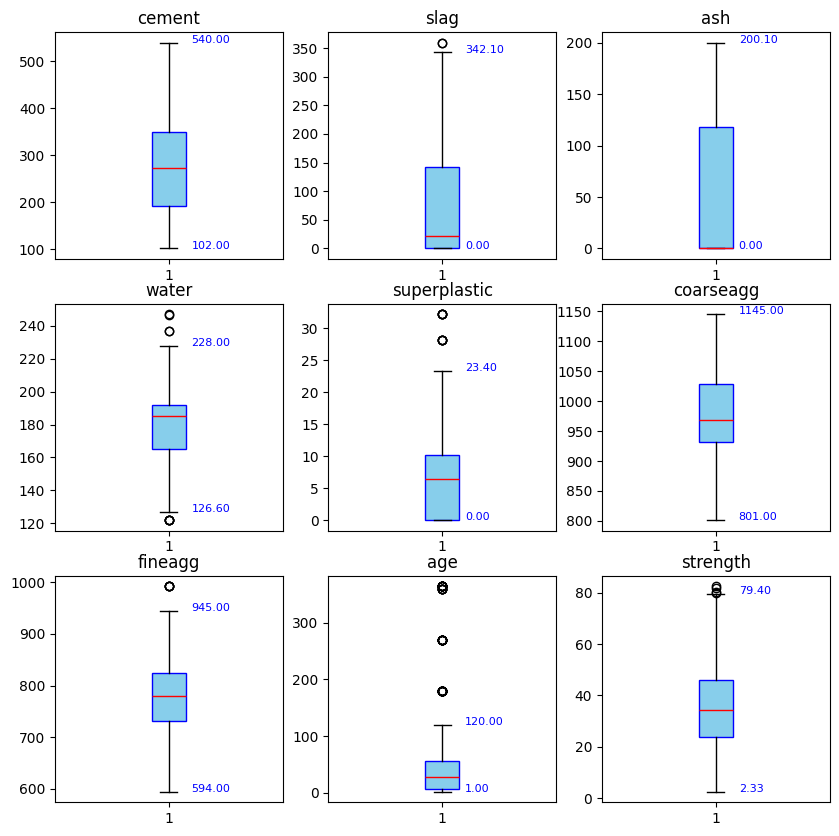

In [25]:
import matplotlib.pyplot as plt

fig,grid=plt.subplots(3,3,figsize=(10,10))
grid=grid.flatten() #if I wanna iterate it needs to be flattened
for i,column in enumerate(concrete.columns):
  boxplot_dict=grid[i].boxplot(concrete[column], patch_artist=True, boxprops=dict(facecolor='skyblue', color='blue'), medianprops=dict(color='red'))
  grid[i].set_title(f'{column}')  # Set the title for each subplot
  # Extract whisker values
  lower_whisker = boxplot_dict['whiskers'][0].get_ydata()[1]  # First whisker (lower)
  upper_whisker = boxplot_dict['whiskers'][1].get_ydata()[1]  # Second whisker (upper)

  # Annotate whisker values on the plot
  grid[i].text(1.1, lower_whisker, f'{lower_whisker:.2f}', color='blue', fontsize=8)
  grid[i].text(1.1, upper_whisker, f'{upper_whisker:.2f}', color='blue', fontsize=8)

# Remove unused subplots (if the number of columns is less than the number of axes)
for j in range(len(concrete.columns), len(grid)):
    fig.delaxes(grid[j])
plt.show()

In [58]:
concrete_outlier=concrete[(concrete['age']>120)]
print(concrete_outlier.shape[0])
print(f'{round((concrete_outlier.shape[0]/concrete.shape[0])*100,3)}% of the data are outliers')

59
5.728% of the data are outliers


Anlanysing the outliers, there are 59 outlier data samples, all this we can extract them from the dataset to use it in the modeling.


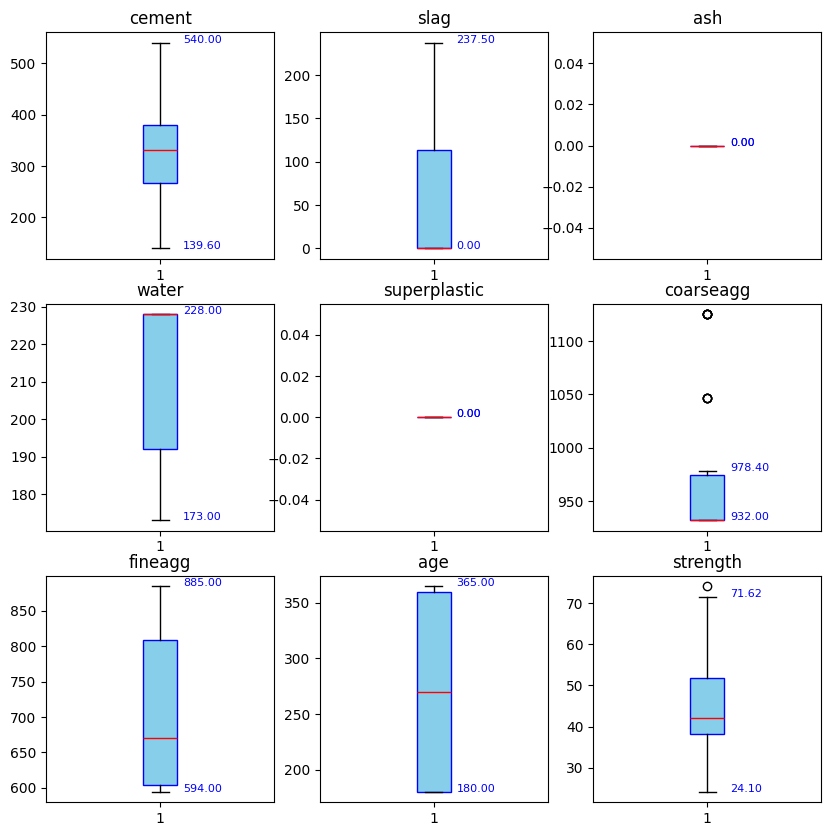

In [59]:
import matplotlib.pyplot as plt

fig,grid=plt.subplots(3,3,figsize=(10,10))
grid=grid.flatten() #if I wanna iterate it needs to be flattened
for i,column in enumerate(concrete_outlier.columns):
  boxplot_dict=grid[i].boxplot(concrete_outlier[column], patch_artist=True, boxprops=dict(facecolor='skyblue', color='blue'), medianprops=dict(color='red'))
  grid[i].set_title(f'{column}')  # Set the title for each subplot
  # Extract whisker values
  lower_whisker = boxplot_dict['whiskers'][0].get_ydata()[1]  # First whisker (lower)
  upper_whisker = boxplot_dict['whiskers'][1].get_ydata()[1]  # Second whisker (upper)

  # Annotate whisker values on the plot
  grid[i].text(1.1, lower_whisker, f'{lower_whisker:.2f}', color='blue', fontsize=8)
  grid[i].text(1.1, upper_whisker, f'{upper_whisker:.2f}', color='blue', fontsize=8)

# Remove unused subplots (if the number of columns is less than the number of axes)
for j in range(len(concrete.columns), len(grid)):
    fig.delaxes(grid[j])
plt.show()

Different filtered were applied, and the best result reduicing the outliers was filtering the age, eliminiating the outliers above 120 days.

This match with the analysis done with the previous capstone project once the data was categorized by type of mix, showing that above that range of age, the samples were limited to mixes with just slag or cement in the mix, make these samples no respresentative of the whole dataset.

###graph age/strength


In [61]:
concrete_pluscat=concrete.copy()
# cuales son los escenarios? 9 (matriz 3x3) , la mitad menos 1 ~ 3
#a) slag-ash b)slag-superplastic c)ash-superplastic

concrete_pluscat['type_mix'] = 'all mix'
concrete_pluscat.loc[
    (concrete_pluscat['slag']>0) & (concrete_pluscat[['superplastic','ash']] == 0).all(axis=1),
    'type_mix',
] = 'slag'
concrete_pluscat.loc[
    (concrete_pluscat['ash']>0) & (concrete_pluscat[['superplastic','slag']] == 0).all(axis=1),
    'type_mix',
] = 'ash'
concrete_pluscat.loc[
    (concrete_pluscat['superplastic']>0) & (concrete_pluscat[['slag','ash']] == 0).all(axis=1),
    'type_mix',
] = 'superplastic'

concrete_pluscat.loc[
    (concrete_pluscat[['slag', 'ash']].gt(0).all(axis=1)) & (concrete_pluscat['superplastic'] == 0),
    'type_mix',
] = 'slag-ash'

concrete_pluscat.loc[
    (concrete_pluscat[['slag', 'superplastic']].gt(0).all(axis=1)) & (concrete_pluscat['ash'] == 0),
    'type_mix',
] = 'slag-superplastic'

concrete_pluscat.loc[
    (concrete_pluscat[['ash', 'superplastic']].gt(0).all(axis=1)) & (concrete_pluscat['slag'] == 0),
    'type_mix',
] = 'ash-superplastic'
concrete_pluscat.loc[
    (concrete_pluscat['cement']>0) & (concrete_pluscat[['superplastic','slag','ash']] == 0).all(axis=1),
    'type_mix',
] = 'just cement'

In [62]:
from bokeh.plotting import figure, show
from bokeh.palettes import Category20
from bokeh.io import output_notebook
import random

output_notebook()


copy_nfile=concrete_pluscat.copy()
type_group=copy_nfile['type_mix'].unique()

if len(type_group)<=2:
  col=[Category20[5][0],Category20[5][3]]
else:
  col=Category20[len(type_group)]


type_mix=sorted(copy_nfile['type_mix'].unique())
gf1=copy_nfile[copy_nfile['type_mix']==type_mix[0]]
gf2=copy_nfile[copy_nfile['type_mix']==type_mix[1]]
gf3=copy_nfile[copy_nfile['type_mix']==type_mix[2]]
gf4=copy_nfile[copy_nfile['type_mix']==type_mix[3]]
gf5=copy_nfile[copy_nfile['type_mix']==type_mix[4]]
gf6=copy_nfile[copy_nfile['type_mix']==type_mix[5]]

z=figure(title='strength vs age by mix_type',height=350)
z.scatter(x=sorted(gf1['age'].unique()),y=gf1.groupby('age')['strength'].mean(),color=col[0],legend_label=type_mix[0])
z.scatter(x=sorted(gf2['age'].unique()),y=gf2.groupby('age')['strength'].mean(),color=col[1],legend_label=type_mix[1])
z.scatter(x=sorted(gf3['age'].unique()),y=gf3.groupby('age')['strength'].mean(),color=col[2],legend_label=type_mix[2])
z.scatter(x=sorted(gf4['age'].unique()),y=gf4.groupby('age')['strength'].mean(),color=col[3],legend_label=type_mix[3])
z.scatter(x=sorted(gf5['age'].unique()),y=gf5.groupby('age')['strength'].mean(),color=col[4],legend_label=type_mix[4])
z.scatter(x=sorted(gf6['age'].unique()),y=gf6.groupby('age')['strength'].mean(),color=col[5],legend_label=type_mix[5])
z.xaxis.axis_label='age (days)'
z.yaxis.axis_label='strength (Mpa)'
z.add_layout(z.legend[0], 'right')
z.background_fill_color = "#eff0e7"
show(z)

# Preprocessing data

In [63]:
print(concrete_pluscat.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
 9   type_mix      1030 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 80.6+ KB
None


the dataframe is build by the raw materials that composed the concrete mix  (kg/m^3), age (days) and compressive strength of the sample.

with the idea of see the impact of adding   categorical values to the model, depending the type of mix, cause of this this categories were prevously created to add to the dataframe.

    * all mix
    * slag
    * ash
    * superplastic
    * slag-ash
    * slag-superplastic
    * ash-superplastic.
    * just cement


In [64]:
concrete_pluscat.groupby('type_mix')['strength'].count()

,strength
type_mix,
all mix,225
ash,6
ash-superplastic,233
just cement,209
slag,164
slag-superplastic,170
superplastic,23


there is no slag-ash mix. so when the get_dummies method is applyed this will give 6 dummie columns instead of 7, considering that the first one will be drop.
 it's possible to observe that the amount of samples that contains superplastic and ash are reduced and it will impact in the resuts, probably being this kind of mixes the ones that presents more errors in the predictions.

###Analysing data distribution

  As was mentioned before, there are samples distributed in all the categories related with the type of mix before the 120 days as showed the boxplot and the graph strenght vs age of the whole data classified.


The dummies for the categorical values were created so we can added to the model later:

In [67]:
# Create the dataframe with all the numerical and categorical values
concrete_data=pd.get_dummies(data=concrete_pluscat,columns=['type_mix'],drop_first=True).astype(int)
concrete_data.head()
concrete_data.shape


(1030, 15)

the data was filtered so we can run the first model with the whole dataset and the filtered data to see perfomance, afterwards just the dataset with the filtered data (no outliers) will be used to asess the perfomance of the different models.

In [228]:
RED = "\033[31m"
RESET = "\033[0m"

ptg_data28=(len(concrete[concrete['age']<=120])/len(concrete))*100


print(f'The percentage of data under 100 days over the total is {RED}{round(ptg_data28,3)} %{RESET}')

print(f"{RED}{len(concrete[concrete['age']>120])}{RESET} samples are over 100 days")
print(f"{RED}{len(concrete[concrete['age']<=120])}{RESET} samples are under 100 days")

The percentage of data under 100 days over the total is 94.272 %
59 samples are over 100 days
971 samples are under 100 days


Using mathematical operations we can observe that ***93,981 %*** of the samples are obtain before the 120 days, so this data is the most representative of the whole dataset, being the samples above that age noise in the model as they also represent values of just two particular mixes (slag and all mix) and are clear outliers for the feature 'age'. Cause of this, the samples above 120 days will be removed of the model an this will predict compressive strength between 0 and 120 days.

In [229]:
concrete_pluscat[concrete_pluscat['age']<=120].groupby('type_mix')['strength'].count()

,strength
type_mix,
all mix,225
ash,6
ash-superplastic,233
just cement,178
slag,136
slag-superplastic,170
superplastic,23


With the filter it's reduced the amount of mixes with just cement and slag.


### Creation of the taining and testing samples
 The samples are split in testing and training data for dependent and independent variables using 'train_test_split' method. so we can use this data for further modeling, modeling over two different set of data:

    * Full data
    * Data filtered by age (age under 100 days)


In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X=concrete_data.drop(columns=['strength'])
y=concrete_data['strength']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)


In [69]:
# concrete_model_data=concrete_data[concrete_data['age']<=120]

concrete_model_data=concrete_data[concrete_data['age']<=120]
X_100=concrete_model_data.drop(columns=['strength'])
y_100=concrete_model_data['strength']
X_train_100,X_test_100,y_train_100,y_test_100=train_test_split(X_100,y_100,test_size=0.2)

In [70]:
# Seprating my numeric variables and nominal/categorical values
num_col=[a for a in concrete.columns]
num_col.remove('strength')
#numerical values
X_train_num=X_train[num_col]
X_test_num=X_test[num_col]
#nominal values
X_train_nom=X_train.drop(columns=num_col)
X_test_nom=X_test.drop(columns=num_col)

#------------------------------------------------------------------------------

#nominal values dataset 2 (120 days)
X_train_nom_100=X_train_100.drop(columns=num_col)
X_test_nom_100=X_test_100.drop(columns=num_col)
#numerical values dataset 2 (120 days)
X_train_num_100=X_train_100[num_col]
X_test_num_100=X_test_100[num_col]


##Scalling the data

In [72]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler,PolynomialFeatures,FunctionTransformer
from sklearn import linear_model
from sklearn.pipeline import make_pipeline

scale_data=StandardScaler()


X_train_num_scale=scale_data.fit_transform(X_train_num)
X_test_num_scale=scale_data.fit_transform(X_test_num)

#dataset 2 (120 days)
X_train_num_scale_100=scale_data.fit_transform(X_train_num_100)
X_test_num_scale_100=scale_data.fit_transform(X_test_num_100)

print(pd.DataFrame(X_train_num_scale))

            0         1         2         3         4         5         6  \
0   -1.209927  1.289168  1.366247  0.597084  0.504638 -1.177815 -0.909431   
1    1.008559 -0.621964  0.602769 -1.127913  1.355685 -0.438857  0.911187   
2    0.893810  0.228723 -0.861863 -2.573180  2.887570 -1.534553  2.744275   
3   -0.291933 -0.855028  0.680675 -1.640750  1.015266  0.427508  1.584566   
4   -0.416245 -0.855028  0.602769  0.224112  0.164219 -0.298710  0.936127   
..        ...       ...       ...       ...       ...       ...       ...   
819  1.362369 -0.598657  1.194854 -0.615076  0.334429 -1.916773 -0.273462   
820  1.065934 -0.855028 -0.861863  0.503841 -1.027247 -0.413376  0.162988   
821 -0.301495 -0.855028  0.618350  0.457219 -0.176200 -0.311450  1.060827   
822 -1.353364  1.056103  1.132529  2.601810 -0.005990 -1.317962 -1.445641   
823 -0.043310 -0.855028 -0.861863  0.457219 -1.027247 -0.056637  1.048357   

            7  
0   -0.281844  
1   -0.281844  
2   -0.632482  
3   -0.2818

# **Testing Models**

###Lineal model

In [73]:

#using all data
lineal=linear_model.LinearRegression()
lineal.fit(X_train_num_scale,y_train)
l0=round(lineal.score(X_train_num_scale,y_train),3)
l1=round(lineal.score(X_test_num_scale,y_test),3)
score_lineal=[l0,l1]

#dataset 2 (120 days)
lineal_100=linear_model.LinearRegression()
lineal_100.fit(X_train_num_scale_100,y_train_100)
la=round(lineal_100.score(X_train_num_scale_100,y_train_100),3)
lb=round(lineal_100.score(X_test_num_scale_100,y_test_100),3)
score_lineal_100=[la,lb]
df_lineal=pd.DataFrame({'type_score':['Training','Testing'],'all data R^2':score_lineal,'filtered data R^2':score_lineal_100}).set_index('type_score')
print('values of scores for lineal model')
print(df_lineal)

values of scores for lineal model
            all data R^2  filtered data R^2
type_score                                 
Training           0.639              0.761
Testing            0.505              0.732


So it is clear that the model performs better with the filtered data, so from now on we will analysed the model with the filtered dataset.

###Reciprocal logaritmic


In [197]:
import numpy as np

def addReciprocalLogFeatures(numeric):
    log_feats = numeric.copy()
    valid = (log_feats != 1) & (log_feats > 0)
    log_feats[valid] = np.log(log_feats[valid]) / np.log(10)
    log_feats[log_feats <= 0] = 1e-10
    rec_log_feats = log_feats
    return np.hstack([numeric, rec_log_feats, numeric * rec_log_feats])

X_train_reclog_120 = addReciprocalLogFeatures(X_train_num_scale_100)
X_test_reclog_120 = addReciprocalLogFeatures(X_test_num_scale_100)


In [235]:
BLUE = "\033[1;34m"
RED = "\033[1;31m"
GREEN= "\033[1;32m"
RESET = "\033[0m"

lineal_rl_120=linear_model.LinearRegression()
lineal_rl_120.fit(X_train_reclog_120,y_train_100)
predicted_reclog_100=lineal_rl_120.predict(X_test_reclog_120)
print(f"the R^2 score for the train data of the {RED}reciprocal log model{RESET} is {BLUE}{round(lineal_rl_120.score(X_train_reclog_120,y_train_100),3)}{RESET}")
print(f"the R^2 score for the test data of the  {RED}reciprocal log model{RESET} is {BLUE}{round(lineal_rl_120.score(X_test_reclog_120,y_test_100),3)}{RESET}")

the R^2 score for the train data of the reciprocal log model is 0.843
the R^2 score for the test data of the  reciprocal log model is 0.835


In [216]:

print(f"{BLUE}Rec.log model{RESET}")
df1 = pd.DataFrame({"Predicted_120": predicted_reclog_100, "Actual_120": y_test_100})
df1['% Difference(120 days)'] = (abs(df1['Predicted_120']-df1['Actual_120'])/df1['Actual_120'])*100

print("Percentage Difference between Predicted and Actual Values (rec.log model with age bellow 120 days)")
print(df1.head())
print(f"\nMean % Difference between Predicted and Actual Values of data bellow 120 days:{BLUE}{str(round(df1['% Difference(120 days)'].mean(),3))}%{RESET}")

Rec.log model
Percentage Difference between Predicted and Actual Values (rec.log model with age bellow 120 days)
     Predicted_120  Actual_120  % Difference(120 days)
551      40.152366          49               18.056396
576      46.925572          55               14.680778
48       52.533704          49                7.211640
757      25.896499          29               10.701726
348      46.380049          51                9.058727

Mean % Difference between Predicted and Actual Values of data bellow 120 days:17.141%


**The results gives a clear signs that the reciprocal model gives the best R^2 score between this two lineal models. Altought the score is acceptable, still it is possible to obtain better results in this data with multi variable with a model as decision trees or neural network which support no lineal data analysis.
 In this project we wil focus on neural network and compare the results obtained with this model an the one obtained with lineal regression.**

## ***Adding nominal values***
  The two best models were selected and added the nominal values, so in this way will be possible to asses their performance.
  
  * Cubic model with all data
  * rec.log model with filtered data

In [233]:
X_train_ln_full_100 = np.hstack([X_train_reclog_100, X_train_nom_100])
X_test_ln_full_100 = np.hstack([X_test_reclog_100, X_test_nom_100])
X_train_ln_full.shape

(824, 170)

In [234]:


ln_model_100= linear_model.RidgeCV()
ln_model_100.fit(X_train_ln_full_100,y_train_100)
train_predict_ln_100=ln_model_100.predict(X_train_ln_full_100)
test_predict_ln_100=ln_model_100.predict(X_test_ln_full_100)

print(f"{BLUE}logaritmic model filtered (bellow 120 days){RESET}")
print(f'For the train data,the R^2 for the {GREEN}reciprocal log model{RESET} is : {round(ln_model_100.score(X_train_ln_full_100,y_train_100),3)}')
print(f'For the test data,the R^2 for the {GREEN}reciprocal log model{RESET} is : {round(ln_model_100.score(X_test_ln_full_100,y_test_100),3)}')

logaritmic model filtered (bellow 120 days)
For the train data,the R^2 for the reciprocal log model is : 0.844
For the test data,the R^2 for the reciprocal log model is : 0.839


In [236]:

print(f"{BLUE}Rec.log model{RESET}")
df1 = pd.DataFrame({"Predicted_120": test_predict_ln_100, "Actual_120": y_test_100})
df1['% Difference(120 days)'] = (abs(df1['Predicted_120']-df1['Actual_120'])/df1['Actual_120'])*100

print("Percentage Difference between Predicted and Actual Values (rec.log model with age bellow 120 days)")
print(df1.head())
print(f"\nMean % Difference between Predicted and Actual Values of data bellow 120 days:{BLUE}{str(round(df1['% Difference(120 days)'].mean(),3))}%{RESET}")

Rec.log model
Percentage Difference between Predicted and Actual Values (rec.log model with age bellow 120 days)
     Predicted_120  Actual_120  % Difference(120 days)
551      39.975880          49               18.416571
576      46.854511          55               14.809980
48       52.603977          49                7.355055
757      27.429136          29                5.416772
348      45.728789          51               10.335708

Mean % Difference between Predicted and Actual Values of data bellow 120 days:16.522%


#Neural Network

In [83]:
#using neural network
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier, MLPRegressor


In [84]:
Xnn=concrete_pluscat.drop(columns='strength')
y=concrete_pluscat['strength']
X_train,X_test,y_train,y_test=train_test_split(Xnn,y,test_size=0.2)

In [85]:
preprocessor = make_column_transformer(
    (OneHotEncoder(), make_column_selector(dtype_include=object)),
    (StandardScaler(), make_column_selector(dtype_include=np.number)),
)
preprocessor

ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x78e8d2ced490>),
                                ('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x78e8d3444450>)])

In [86]:
neural_net = MLPRegressor(hidden_layer_sizes=(25,),#7,0.003 works 18,0.003 better 25.0.003
    max_iter=1000,
    learning_rate_init=0.003,
    )
C_strength_model = make_pipeline(preprocessor, neural_net)
C_strength_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x78e8d2ced490>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x78e8d3444450>)])),
                ('mlpregressor',
                 MLPRegressor(hidden_layer_sizes=(25,),
                              learning_rate_init=0.003, max_iter=1000))])

In [87]:
#Hyperparameters search

#first of all we create a list of parameters that we want to evaluate
#this parameter list is a dictionary with the key values representing
#the variable that we want to analyse
#we can check the parameters that we can assess with the method get_params
# applying it over the pipeline
C_strength_model.get_params().keys()

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'columntransformer', 'mlpregressor', 'columntransformer__force_int_remainder_cols', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__verbose_feature_names_out', 'columntransformer__onehotencoder', 'columntransformer__standardscaler', 'columntransformer__onehotencoder__categories', 'columntransformer__onehotencoder__drop', 'columntransformer__onehotencoder__dtype', 'columntransformer__onehotencoder__feature_name_combiner', 'columntransformer__onehotencoder__handle_unknown', 'columntransformer__onehotencoder__max_categories', 'columntransformer__onehotencoder__min_frequency', 'columntransformer__onehotencoder__sparse_output', 'columntransformer__standardscaler__copy', 'columntransformer__standardscaler__with_mean', 'columntransformer__standardscaler__wit

In [88]:
parameters_nn={
    'mlpregressor__hidden_layer_sizes':[(25,),(28,),(29,)],#[(x, y) for x in range(10, 40) for y in range(0, 10)],(a,) for a in range(15,40)]
    'mlpregressor__max_iter':[1000,1500],
    'mlpregressor__activation':['tanh'],
    'mlpregressor__learning_rate_init':[0.003,0.01]
    }

In [156]:
from sklearn.model_selection import GridSearchCV

grid_search= GridSearchCV(C_strength_model,param_grid=parameters_nn,scoring='r2',cv=5,n_jobs=-1)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x78e8d2ced490>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x78e8d3444450>)])),
                                       ('mlpregressor',
                                        MLPRegressor(hidden_layer_sizes=(25,),
                                                     learning_rate_init=0.003,
                                                     max_iter=1000))]),
             n_jobs=-1,
             param_grid={'mlpregressor__activation': ['tanh'],
                         'mlpregressor__hidden_layer_sizes': [(25,), (28,),
                                                              (29,)],
                         'mlpregressor__learning_rate_init': [0.003, 0.01],
                         'mlpregressor__max_iter': [1000, 1500]},
             scoring='r2')

In [158]:
Best_pipeline=grid_search.best_estimator_
grid_search.best_score_

0.8957583464179386

412
-247


<Axes: title={'center': 'Loss Curve'}>

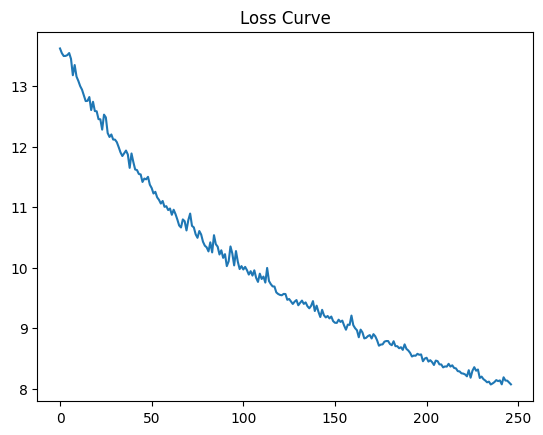

In [159]:
num_iterations = Best_pipeline.named_steps.mlpregressor.n_iter_
print(num_iterations)#The length of the number of iterations is
display_iter=int(-(num_iterations*0.60))
print(display_iter)
# equal to the length of the error given by the loss curve
#loss curve
loss_curve=Best_pipeline.named_steps.mlpregressor.loss_curve_
pd.Series(loss_curve[display_iter:]).plot.line(title='Loss Curve')

In [160]:
print(f" The R^2 for the training data is {round(Best_pipeline.score(X_train, y_train),3)}")
print(f"the R^2 for the testing data is {round(Best_pipeline.score(X_test, y_test),3)}")

 The R^2 for the training data is 0.942
the R^2 for the testing data is 0.906


In [93]:
prediction_nn=Best_pipeline.predict(X_test)
dfnn = pd.DataFrame({"Predicted": prediction_nn, "Actual": y_test})
dfnn['% Difference'] = (abs(dfnn['Predicted']-dfnn['Actual'])/dfnn['Actual'])*100
print("Percentage Difference between Predicted and Actual Values (feedforward neural network)")
print(dfnn.head())
print("\nMean % Difference between Predicted and Actual Values: " + str(round(dfnn['% Difference'].mean(),3)) +"%")

Percentage Difference between Predicted and Actual Values (feedforward neural network)
     Predicted  Actual  % Difference
673   1.706013    7.84     78.239626
731   9.927612    9.45      5.054099
582  38.243683   42.55     10.120603
404  16.094840   15.52      3.703869
539  52.953325   50.95      3.931942

Mean % Difference between Predicted and Actual Values: 12.409%


In [244]:
filtred_data=concrete_pluscat[concrete_pluscat['age']<=120]
Xnn_120=filtred_data.drop(columns='strength')
y_120=filtred_data['strength']
X_train_nn,X_test_nn,y_train_nn,y_test_nn=train_test_split(Xnn_120,y_120,test_size=0.2)
parameters_nn_120={
    'mlpregressor__hidden_layer_sizes':[(a,)for a in range(12,19)],#[(x, y) for x in range(10, 40) for y in range(0, 10)],(a,) for a in range(15,40)]
    'mlpregressor__max_iter':[3500,4000],
    'mlpregressor__activation':['tanh'],
    'mlpregressor__learning_rate_init':[0.01,0.03]
    }

In [192]:
grid_search_120= GridSearchCV(C_strength_model,param_grid=parameters_nn_120,scoring='r2',n_jobs=-1)
grid_search_120.fit(X_train_nn,y_train_nn)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x78e8d2ced490>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x78e8d3444450>)])),
                                       ('mlpregressor',
                                        MLPRegressor(hidden_layer_sizes=(25,),
                                                     learning_rate_init=0.003,
                                                     max_iter=1000))]),
             n_jobs=-1,
             param_grid={'mlpregressor__activation': ['tanh'],
                         'mlpregressor__hidden_layer_sizes': [(12,), (13,),
                                                              (14,), (15,),
                                                              (16,), (17,),
                                                              (18,)],
                         'mlpregressor__learning_rate_init': [0.01, 0.03],
                         'mlpregressor__max_iter': [3500, 4000]},
             scoring='r2')

In [238]:
Best_pipeline_120=grid_search_120.best_estimator_
grid_search_120.best_score_

0.8861557544239961

In [239]:
print(f" The R^2 for the training data is {round(Best_pipeline_120.score(X_train_nn, y_train_nn),3)}")
print(f"the R^2 for the testing data is {round(Best_pipeline_120.score(X_test_nn, y_test_nn),3)}")

 The R^2 for the training data is 0.961
the R^2 for the testing data is 0.909


1497
-898


<Axes: title={'center': 'Loss Curve'}>

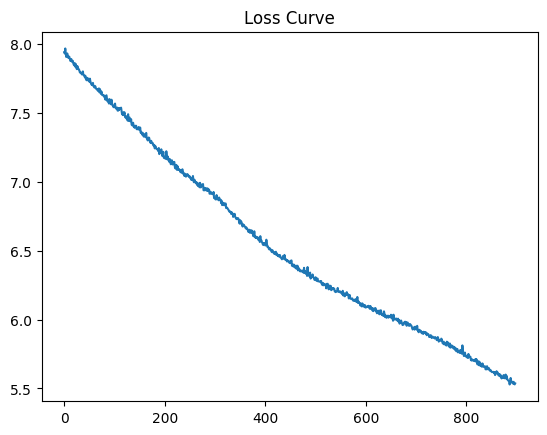

In [240]:
num_iterations_120 = Best_pipeline_120.named_steps.mlpregressor.n_iter_
print(num_iterations_120)#The length of the number of iterations is
display_iter2=int(-(num_iterations_120*0.60))
print(display_iter2)
# equal to the length of the error given by the loss curve
#loss curve
loss_curve2=Best_pipeline_120.named_steps.mlpregressor.loss_curve_
pd.Series(loss_curve2[display_iter2:]).plot.line(title='Loss Curve')

In [246]:
prediction_nn=Best_pipeline_120.predict(X_test_nn)

In [247]:
print(f"{BLUE}Rec.log model{RESET}")
df1 = pd.DataFrame({"Predicted_120": prediction_nn, "Actual_120": y_test_nn})
df1['% Difference(120 days)'] = (abs(df1['Predicted_120']-df1['Actual_120'])/df1['Actual_120'])*100

print("Percentage Difference between Predicted and Actual Values (rec.log model with age bellow 120 days)")
print(df1.head())
print(f"\nMean % Difference between Predicted and Actual Values of data bellow 120 days:{BLUE}{str(round(df1['% Difference(120 days)'].mean(),3))}%{RESET}")

Rec.log model
Percentage Difference between Predicted and Actual Values (rec.log model with age bellow 120 days)
      Predicted_120  Actual_120  % Difference(120 days)
1004      29.537437       27.22                8.513730
104       14.301773       11.98               19.380409
348       49.180886       51.26                4.056016
457       25.364352       25.37                0.022262
621       16.645739       15.52                7.253473

Mean % Difference between Predicted and Actual Values of data bellow 120 days:7.543%


# Conclusion

  The best performance was obtain with the filtered data neural network model, showing clear signs that a no lineal model works better for a multivariable dataset, beside the filtered data gives an R^2 model that has better variance of the error's value in the loss function graph. giving a smother line than the one with the whole dataset. Also it shows a lower variation between the predictive value and the real value, reaching a mean variance of around 7%.